 # 10. Quantum Circuit Optimization (transpilation)

Toshinari Itoko (June 21, 2024)

*Approximate QPU time to run this experiment is 15 s.*

Table of contents:
- Part 1. Running GHZ circuits with different optimization levels
- Part 2. Qiskit Transpiler

Note: Some cells of part 2 are copied from the notebook "Qiskit Deep dive", written by Matthew Treinish (Qiskit maintainer). Some outputs have been removed to limit file size.

In [1]:
# !pip install 'qiskit[visualization]'
# !pip install qiskit_ibm_runtime qiskit_aer
# !pip install jupyter
# !pip install matplotlib pylatexenc pydot pillow

In [2]:
import qiskit
qiskit.__version__

'1.3.1'

In [3]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.__version__

'0.34.0'

In [4]:
import qiskit_aer
qiskit_aer.__version__

'0.13.3'

# Part 1. Running GHZ circuits with different optimization levels

This lesson will address several aspects of circuit optimization in quantum computing. Specifically, we will see the value of circuit optimization by using optimization settings built into Qiskit. Then we will go a bit deeper and see what you can do as an expert in your particular application area to build circuits in a smart way. Finally, we will take a close look at what goes on during transpilation that helps us optimize our circuits.

## Circuit optimization matters

We first compare the results of running 5-qubit GHZ state ($\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$) preparation circuits with and without optimization.

In [5]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendSamplerV2 as Sampler

In [6]:
from qiskit_ibm_runtime.fake_provider import FakeKyiv

backend = FakeKyiv()

We first use a GHZ circuit naively synthesized as follows.

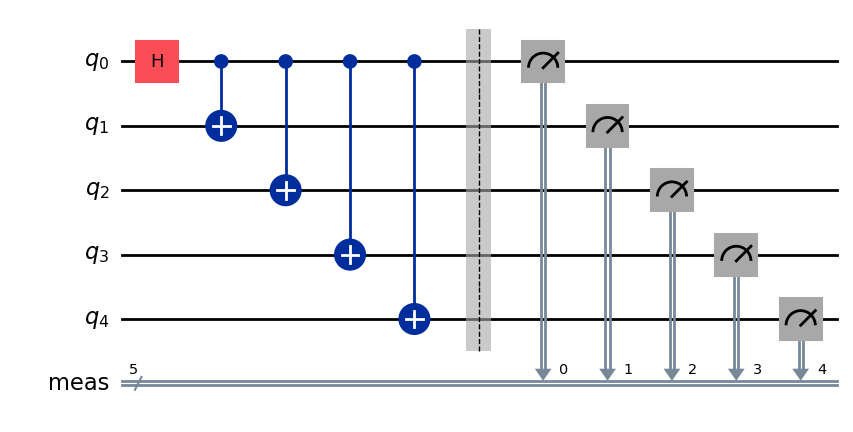

In [7]:
num_qubits = 5

ghz_circ = QuantumCircuit(num_qubits)
ghz_circ.h(0)
[ghz_circ.cx(0,i) for i in range(1,num_qubits)]
ghz_circ.measure_all()
ghz_circ.draw('mpl')

### Optimization level
There are 4 available `optimization_level`s from 0-3. The higher the optimization level the more computational effort is spent to optimize the circuit. Level 0 performs no optimization and just does the minimal amount of work to make the circuit runnable on the selected backend. Level 3 spends the most amount if effort (and typically runtime) to try to optimize the circuit. Level 1 is the default optimization level.

We transpile the circuit without optimization (`optimization_level=0`) and with optimization (`optimization_level=2`).
We see a big difference in the circuit length of transpiled circuits.

optimization_level=0:


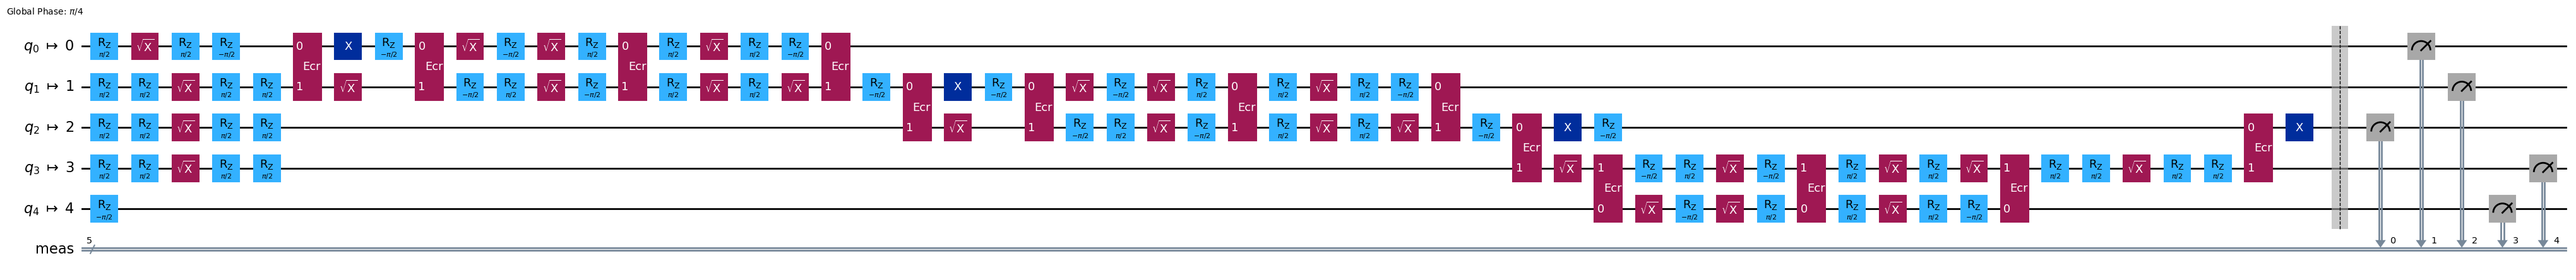

optimization_level=2:


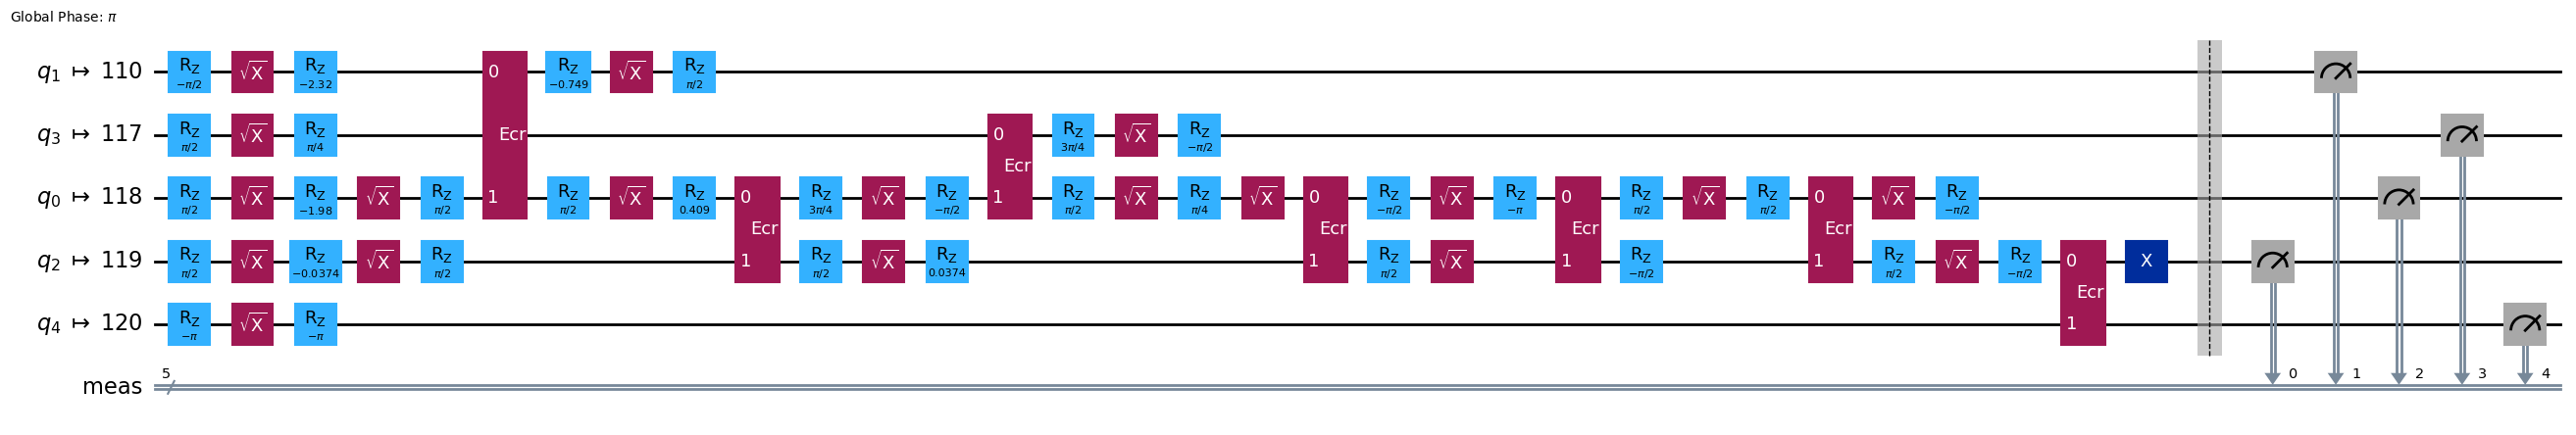

In [8]:
pm0 = generate_preset_pass_manager(optimization_level=0, backend=backend, seed_transpiler=777)
pm2 = generate_preset_pass_manager(optimization_level=2, backend=backend, seed_transpiler=777)
circ0 = pm0.run(ghz_circ)
circ2 = pm2.run(ghz_circ)
print("optimization_level=0:"); display(circ0.draw('mpl', idle_wires=False, fold=-1))
print("optimization_level=2:"); display(circ2.draw('mpl', idle_wires=False, fold=-1))

### Exercise
Try `optimization_level=1` as well and compare the resulting circuit with the above two. Try it by modifying the code above.

__Solution:__

optimization_level=1:


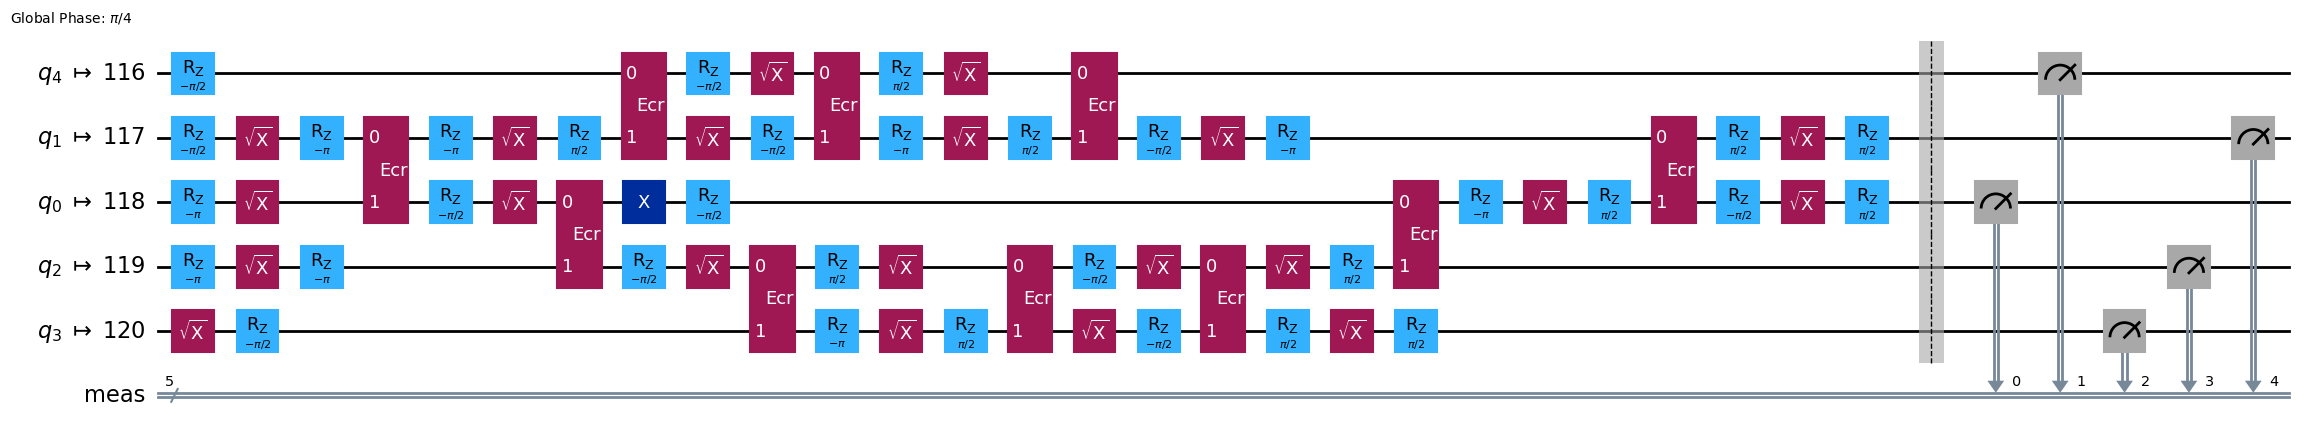

In [9]:
pm1 = generate_preset_pass_manager(optimization_level=1, backend=backend, seed_transpiler=777)
circ1 = pm1.run(ghz_circ)
print("optimization_level=1:"); display(circ1.draw('mpl', idle_wires=False, fold=-1))

Run on a fake backend (noisy simulation). See Appendix 1 for how to run on a real backend.

In [10]:
# run the circuits on the fake backend (noisy simulator)
sampler = Sampler(backend=backend)
job = sampler.run([circ0, circ2], shots=10000)
print(f"Job ID: {job.job_id()}")

Job ID: 5f24183d-9635-475e-951c-e4f34e6ac157


In [11]:
# get results
result = job.result()
unoptimized_result = result[0].data.meas.get_counts()
optimized_result = result[1].data.meas.get_counts()

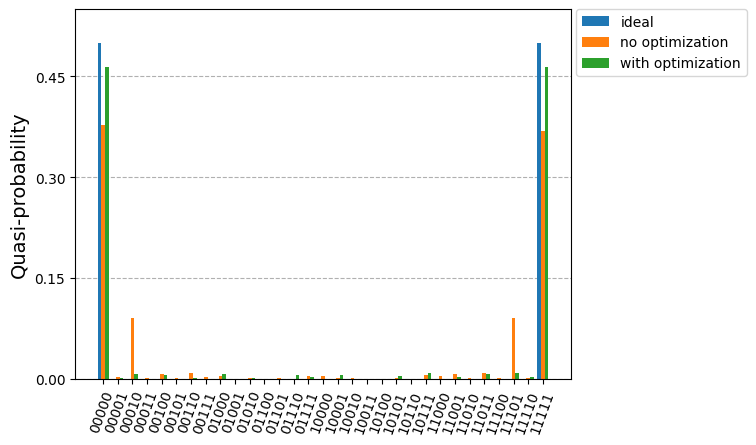

In [12]:
from qiskit.visualization import plot_histogram
# plot
sim_result = {'0'*5:0.5, '1'*5:0.5}
plot_histogram(
    [result for result in [sim_result, unoptimized_result, optimized_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "no optimization",
        "with optimization",
    ],
)

## Circuit synthesis matters

We next compare the results of running two differently synthesized 5-qubit GHZ state ($\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$) preparation circuits.

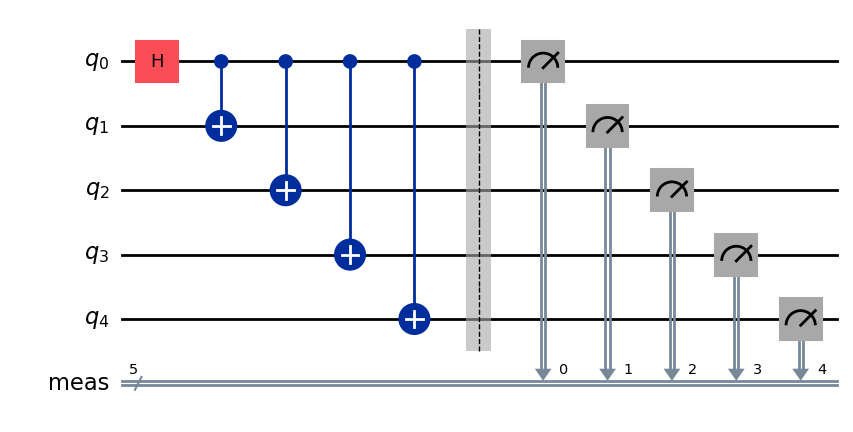

In [13]:
# Original GHZ circuit (naive synthesis)
ghz_circ.draw('mpl')

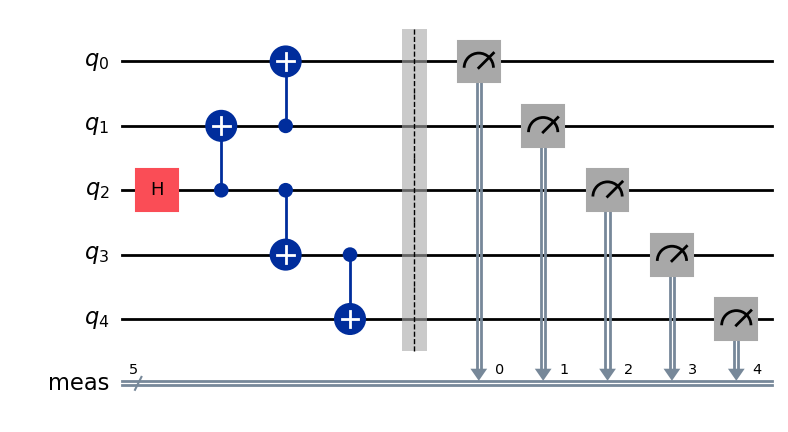

In [14]:
# A cleverly-synthesized GHZ circuit
ghz_circ2 = QuantumCircuit(5)
ghz_circ2.h(2)
ghz_circ2.cx(2, 1)
ghz_circ2.cx(2, 3)
ghz_circ2.cx(1, 0)
ghz_circ2.cx(3, 4)
ghz_circ2.measure_all()
ghz_circ2.draw('mpl')

original synthesis:


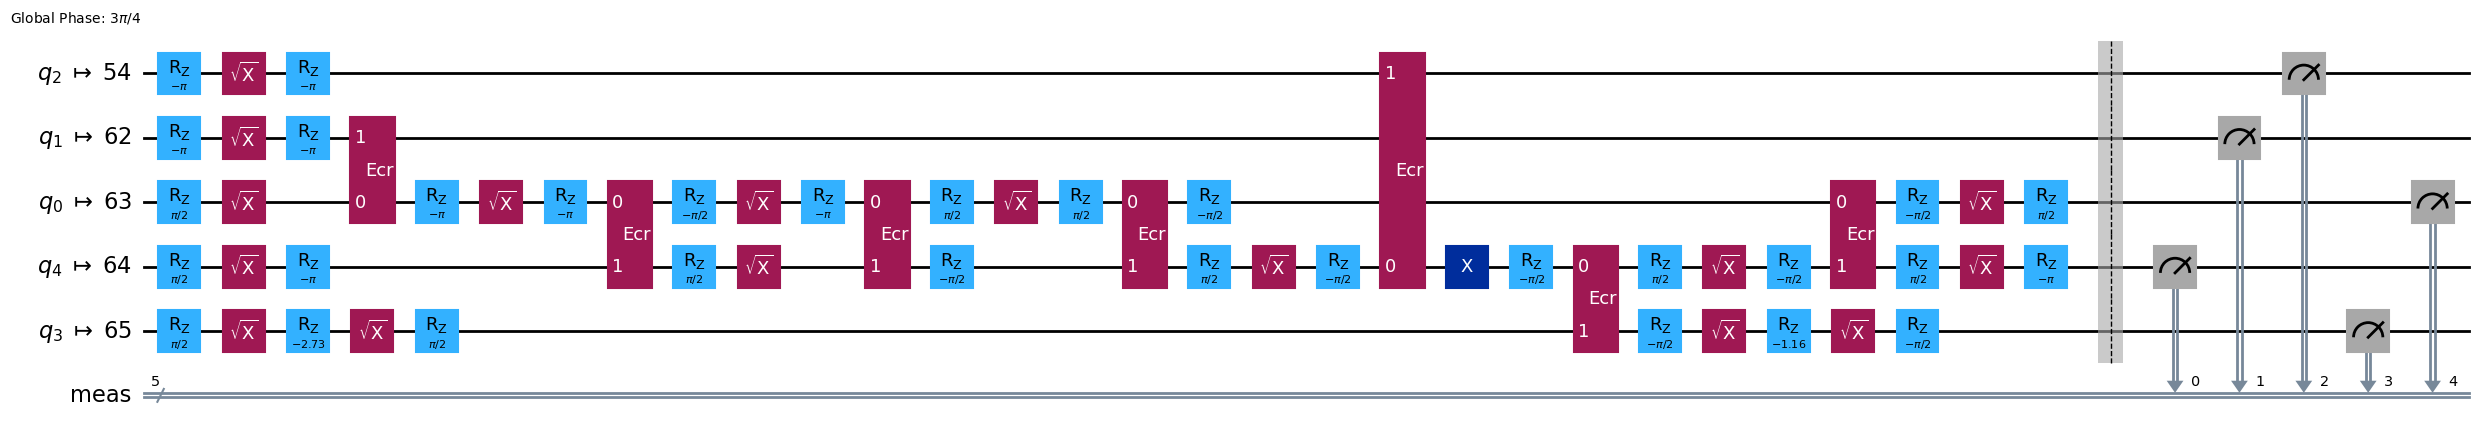

new synthesis:


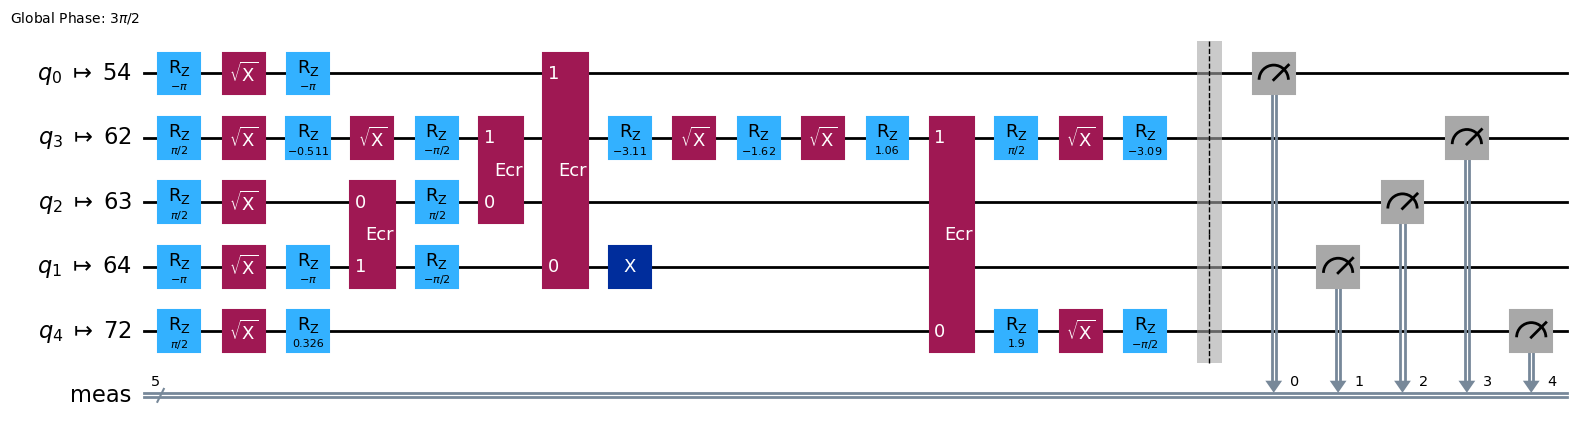

In [15]:
# transpile both with the same optimization level 2
circ_org = pm2.run(ghz_circ)
circ_new = pm2.run(ghz_circ2)
print("original synthesis:"); display(circ_org.draw('mpl', idle_wires=False, fold=-1))
print("new synthesis:"); display(circ_new.draw('mpl', idle_wires=False, fold=-1))

The new synthesis produces a shallower circuit. Why?

This is because the new circuit can be laid out on linearly connected qubits, so on IBM Kyiv's heavy-hexagon coupling graph as well, while the original circuit requires star-shaped connectivity (a degree-4 node) and hence cannot be laid out on the heavy-hex coupling graph, which has nodes at most degree 3. As a result, the original circuit requires qubit routing that adds SWAP gates, increasing the gate count.

What we have done in the new circuit can be seen as a manual "coupling constraint-aware" circuit synthesis. In other words: manually solving circuit synthesis and circuit mapping at the same time.

In [16]:
# run the circuits
sampler = Sampler(backend=backend)
job = sampler.run([circ_org, circ_new], shots=10000)
print(f"Job ID: {job.job_id()}")

Job ID: 556c55ff-c68e-428b-aea8-c1e4e67ba4b5


In [17]:
# get results
result = job.result()
synthesis_org_result = result[0].data.meas.get_counts()
synthesis_new_result = result[1].data.meas.get_counts()

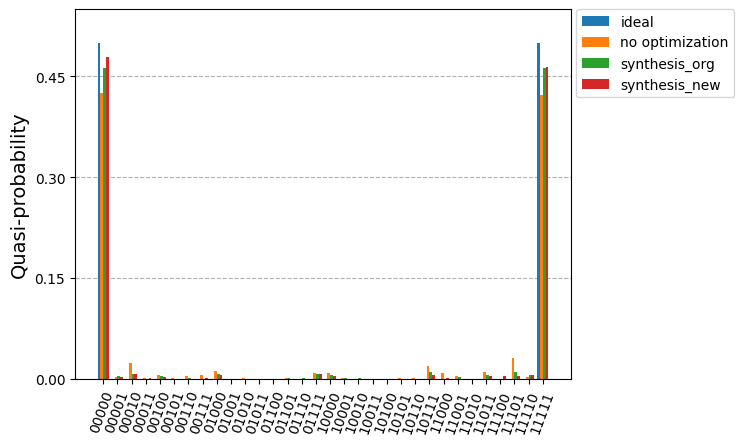

In [18]:
# plot
sim_result = {'0'*5:0.5, '1'*5:0.5}
plot_histogram(
    [result for result in [sim_result, unoptimized_result, synthesis_org_result, synthesis_new_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "no optimization",
        "synthesis_org",
        "synthesis_new",
    ],
)

In general, circuit synthesis depends on application and it's too difficult for a software to cover all possible applications. Qiskit transpiler happens to have no functions of synthesizing GHZ state preparation circuit. In such a case, manual circuit synthesis as shown above is worth considering.

# Part 2. Qiskit Transpiler

In this section, we look into the details of how Qiskit transpiler works using the following toy example circuit.

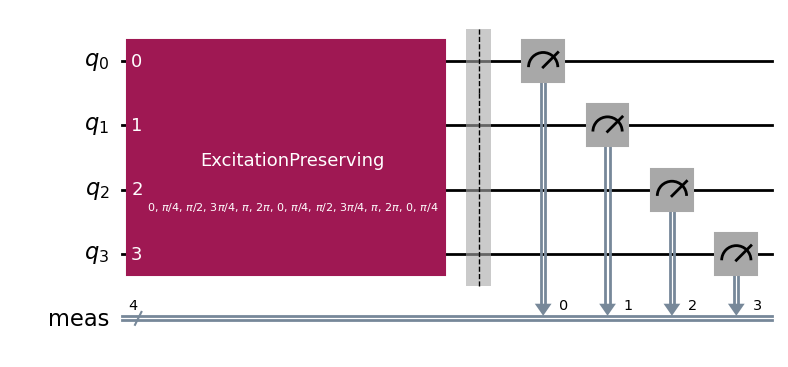

In [19]:
# Build a toy example circuit
from math import pi
import itertools
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ExcitationPreserving

circuit = QuantumCircuit(4, name="Example circuit")
circuit.append(ExcitationPreserving(4, reps=1, flatten=True), range(4))
circuit.measure_all()

value_cycle = itertools.cycle([0, pi / 4, pi / 2, 3*pi / 4, pi, 2* pi])
circuit.assign_parameters([x[1] for x in zip(range(len(circuit.parameters)), value_cycle)], inplace=True)
circuit.draw('mpl')

### Draw the entire Qiskit transpilation flow

We look into the transpiler passes (tasks) for `optimization_level=1`.

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# There is no need to read this entire image, but this outputs all the steps in the transpile() call
# for optimization level 1
pm = generate_preset_pass_manager(1, backend, seed_transpiler=42)
pm.draw()

The flow consists of six stages: 

In [21]:
print(pm.stages)

('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')


### Draw an individual stage

First, let's draw all the tasks (transpiler passes) done in the `init` stage.


In [ ]:
pm.init.draw()

We can run each individual stage. Let's run `init` stage for our circuit. By enabling logger, we can see the details of the run.

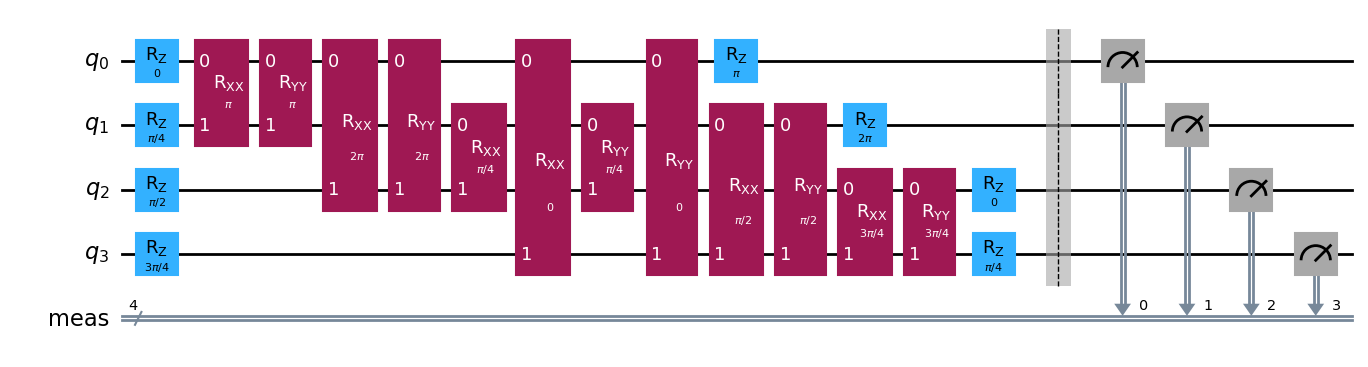

In [23]:
import logging

logger = logging.getLogger()
logger.setLevel("INFO")

init_out = pm.init.run(circuit)
init_out.draw('mpl', fold=-1)

### Exercise
Draw `layout` stage passes and run the stage for the output circuit of the `init` stage (`init_out`), by modifying cells used above.

__Solution:__

In [ ]:
display(pm.layout.draw())
layout_out = pm.layout.run(init_out)
layout_out.draw('mpl', idle_wires=False, fold=-1)

Do the same thing for `translation` stage.

__Solution:__

In [ ]:
display(pm.translation.draw())
basis_out = pm.translation.run(layout_out)
basis_out.draw('mpl', idle_wires=False, fold=-1)

Note: Any individual stage cannot always be run independently (as some of them need to carry over information from one previous stage).

### Optimization Stage

The last default stage in the pipeline is optimization. After we've embedded the circuit for the target the circuit has expanded quite a bit. Most of this is due to inefficiencies in the equivalence relationships from basis translation and swap insertion. The optimization stage is used to try and minimize the size and depth of the circuit. It runs a series of passes in a ```do while``` loop until it reaches a steady output.

In [ ]:
# pm.pre_optimization.draw()
pm.optimization.draw()

In [27]:
logger = logging.getLogger()
logger.setLevel("INFO")
pre_opt_out = pm.pre_optimization.run(basis_out)
opt_out = pm.optimization.run(pre_opt_out)

INFO:qiskit.passmanager.base_tasks:Pass: CheckGateDirection - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GateDirection - 0.46992 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.05889 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00906 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00906 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.22531 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.25392 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.03934 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.11253 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00882 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.11659 (ms)
INFO:qiskit.passmanager.ba

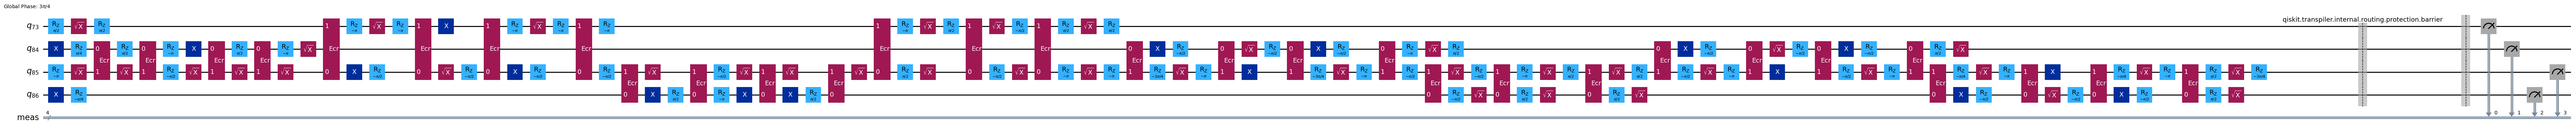

In [28]:
opt_out.draw('mpl', idle_wires=False, fold=-1)

## Two-qubit block optimization using two-qubit unitary synthesis
For level 2 and 3, we have more passes (`Collect2qBlocks`, `ConsolidateBlocks`, `UnitarySynthesis`) for more optimization, namely two-qubit block optimization. (Compare the optimization stage flow for level 2 with that above for level 1)

The two-qubit block optimization is composed of two steps: Collecting and consolidating 2-qubit blocks and synthesizing the 2-qubit unitary matrices. 

In [ ]:
pm2 = generate_preset_pass_manager(2, backend, seed_transpiler=42)
pm2.optimization.draw()

In [30]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks, UnitarySynthesis

# Collect 2q blocks and consolidate to unitary when we expect that we can reduce the 2q gate count for that unitary
consolidate_pm = PassManager([
    Collect2qBlocks(),
    ConsolidateBlocks(target=backend.target),
])

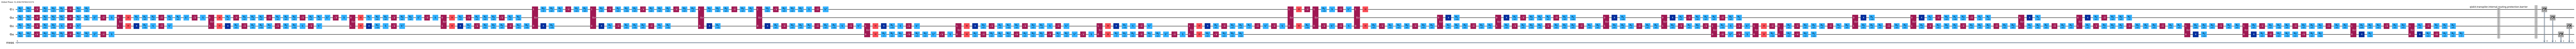

INFO:qiskit.passmanager.base_tasks:Pass: Collect2qBlocks - 0.18787 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 0.44560 (ms)


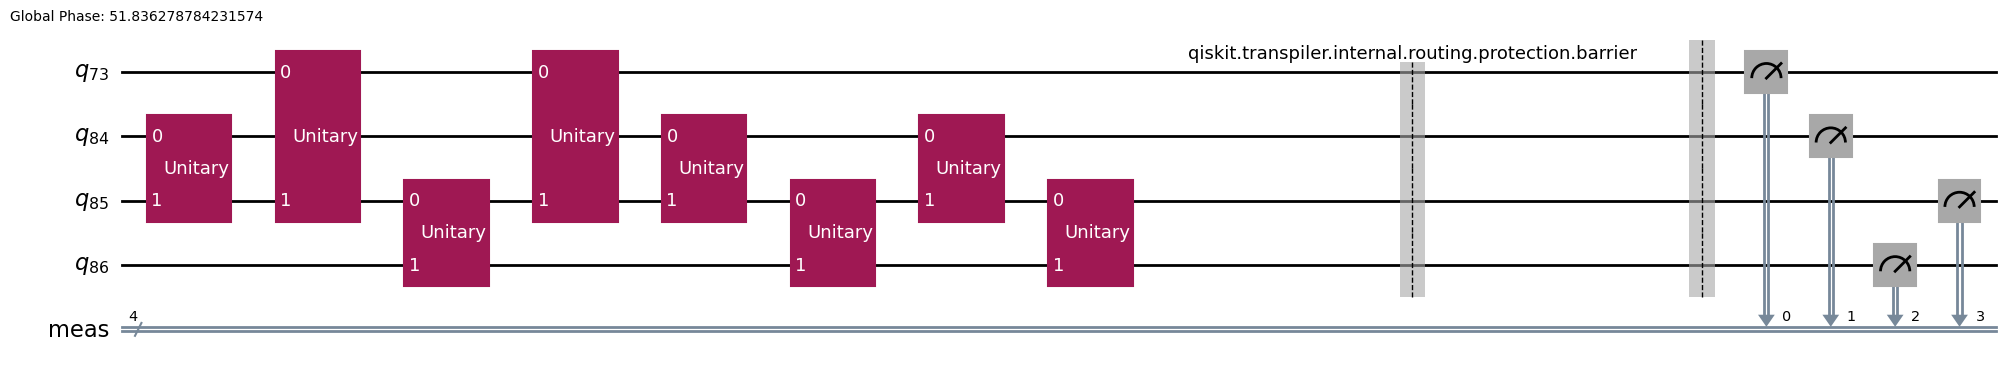

In [31]:
display(pre_opt_out.draw('mpl', idle_wires=False, fold=-1))
consolidated = consolidate_pm.run(pre_opt_out)
consolidated.draw('mpl', idle_wires=False, fold=-1)

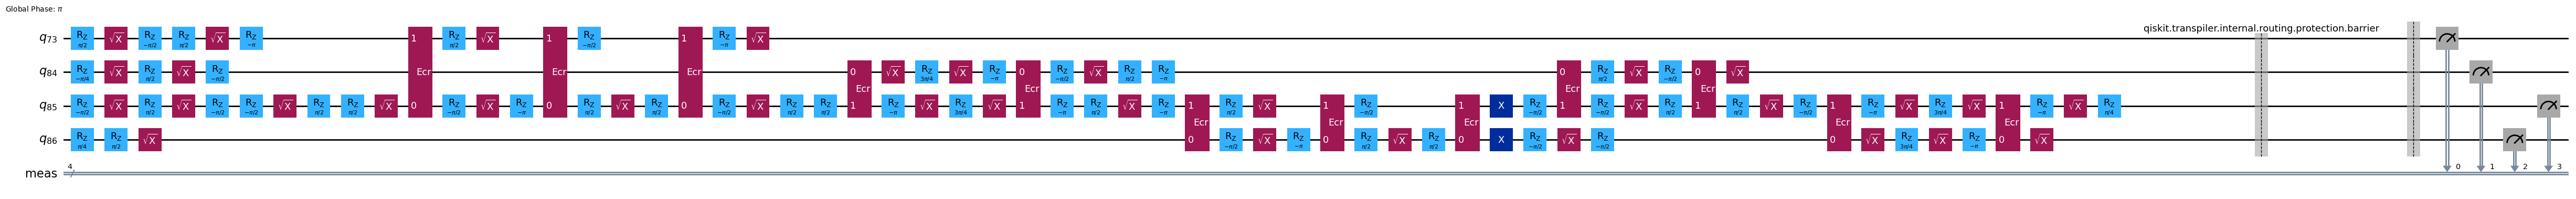

In [32]:
# Synthesize unitaries
UnitarySynthesis(target=backend.target)(consolidated).draw('mpl', idle_wires=False, fold=-1)

In [33]:
logger.setLevel("WARNING")

We saw in Part 2 that the real quantum compiler flow is not that simple and is composed of many passes (tasks). This is mainly due to the software engineering required to ensure performance for a wide range of application circuits and maintainability of the software. Qiskit transpiler would work well in most cases but if you happen to see your circuit is not well optimized by Qiskit transpiler, it would be a good opportunity to research your own application-specific circuit optimization as shown in Part 1.
Transpiler technology is evolving, your R&D contribution is welcome.

# Appendix 0. Bad trials

In [34]:
from qiskit.circuit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

In [35]:
service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')
sampler = Sampler(backend)

In [36]:
circ = QuantumCircuit(3)
circ.ccx(0, 1, 2)
circ.measure_all()
circ.draw()

░ ┌─┐      
   q_0: ──■───░─┤M├──────
          │   ░ └╥┘┌─┐   
   q_1: ──■───░──╫─┤M├───
        ┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2

In [37]:
sampler.run([circ])  # IBMInputValueError will be raised

IBMInputValueError: 'The instruction ccx on qubits (0, 1, 2) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/guides/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/guides/primitives-examples) to see this coupled with operator transformations.'

# Appendix 1. Running GHZ circuits on a real backend

## Circuit optimization matters

We first compare the results of running 5-qubit GHZ state ($\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$) preparation circuits with and without optimization.

In [38]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

In [39]:
service = QiskitRuntimeService()

In [80]:
backend = service.backend('ibm_sherbrooke')

We first use a GHZ circuit naively synthesized as follows.

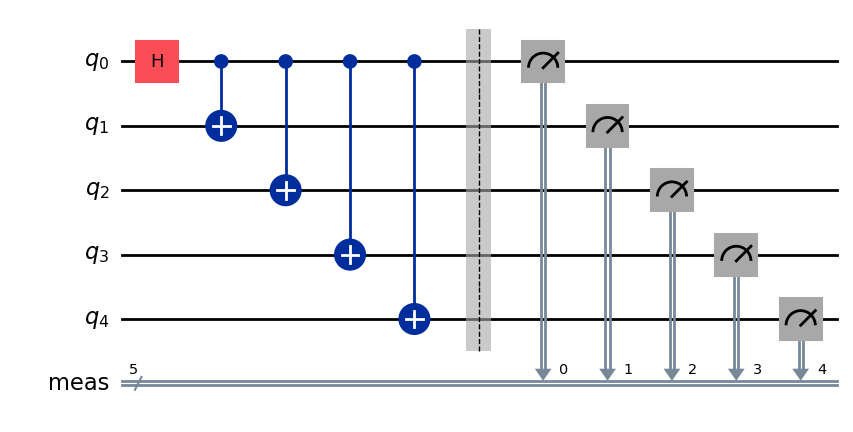

In [81]:
num_qubits = 5

ghz_circ = QuantumCircuit(num_qubits)
ghz_circ.h(0)
[ghz_circ.cx(0,i) for i in range(1,num_qubits)]
ghz_circ.measure_all()
ghz_circ.draw('mpl')

We transpile the circuit without optimization (`optimization_level=0`) and with optimization (`optimization_level=2`).
As you can see, there is a big difference in the circuit length of transpiled circuits.

optimization_level=0:


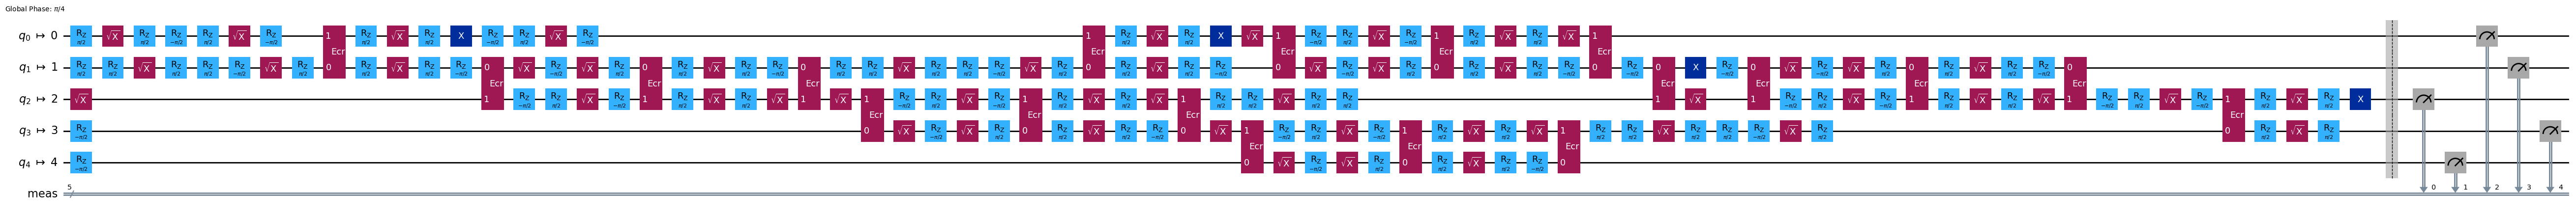

optimization_level=2:


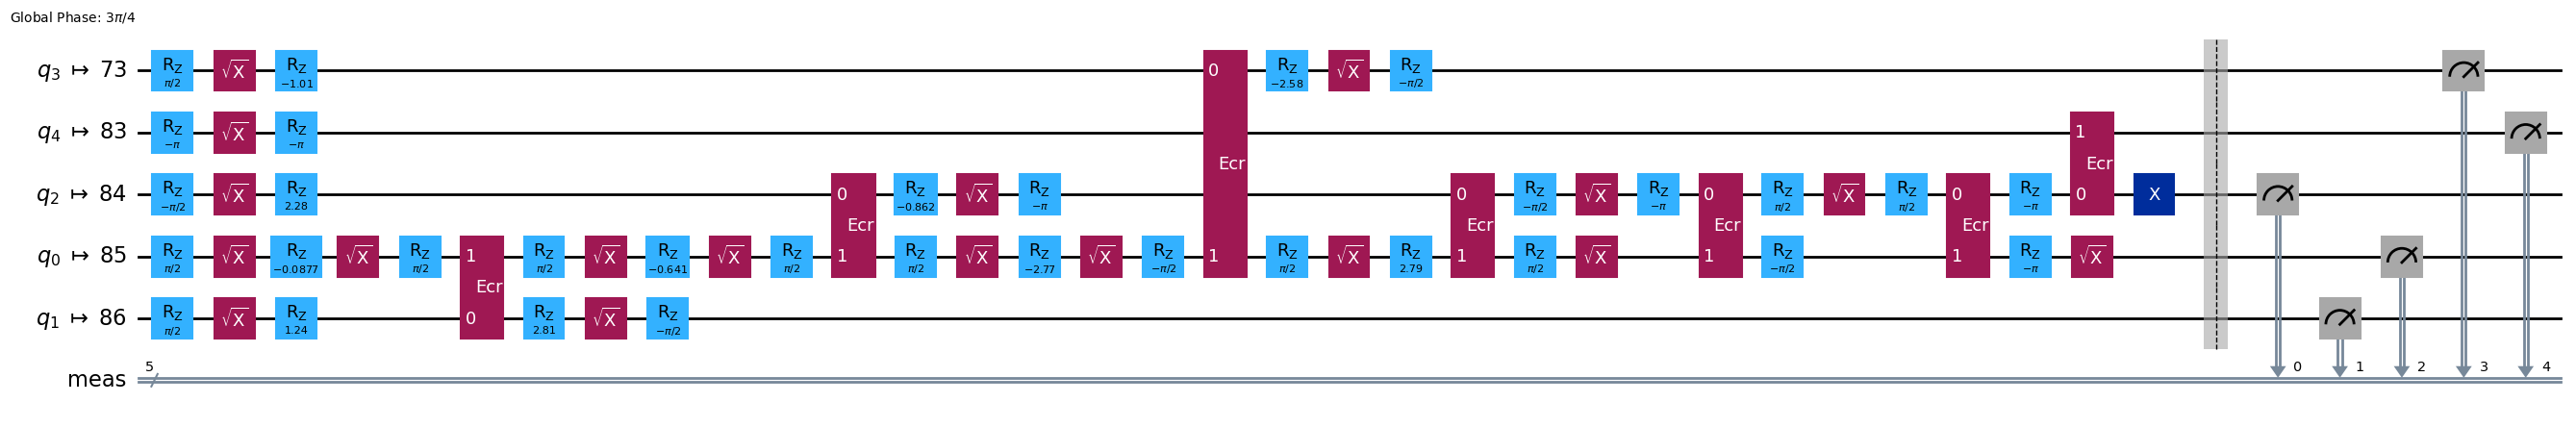

In [85]:
pm0 = generate_preset_pass_manager(optimization_level=0, backend=backend, seed_transpiler=777)
pm2 = generate_preset_pass_manager(optimization_level=2, backend=backend, seed_transpiler=777)
circ0 = pm0.run(ghz_circ)
circ2 = pm2.run(ghz_circ)
print("optimization_level=0:"); display(circ0.draw('mpl', idle_wires=False, fold=-1))
print("optimization_level=2:"); display(circ2.draw('mpl', idle_wires=False, fold=-1))

In [86]:
# run the circuits
sampler = Sampler(backend)
job = sampler.run([circ0, circ2], shots=10000)
print(f"Job ID: {job.job_id()}")

Job ID: csp0gm21k2e0008p7af0


In [78]:
# REPLACE WITH YOUR OWN JOB IDS
job = service.job("csp0gm21k2e0008p7af0")

In [87]:
# get results
result = job.result()
unoptimized_result = result[0].data.meas.get_counts()
optimized_result = result[1].data.meas.get_counts()

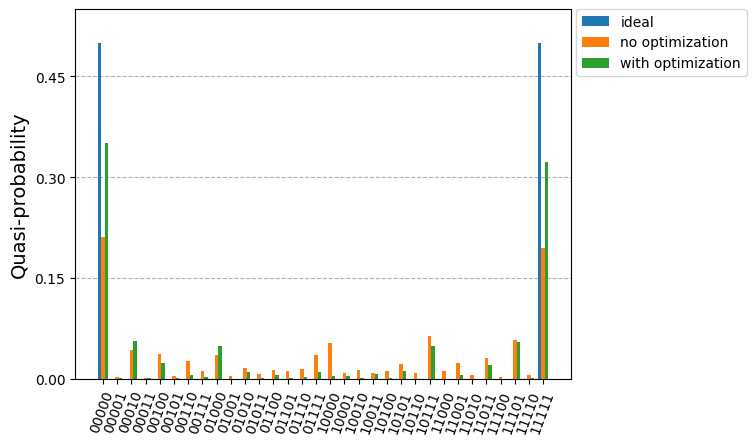

In [88]:
from qiskit.visualization import plot_histogram
# plot
sim_result = {'0'*5:0.5, '1'*5:0.5}
plot_histogram(
    [result for result in [sim_result, unoptimized_result, optimized_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "no optimization",
        "with optimization",
    ],
)

## Circuit synthesis matters

We next compare the results of running two differently synthesized 5-qubit GHZ state ($\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$) preparation circuits.

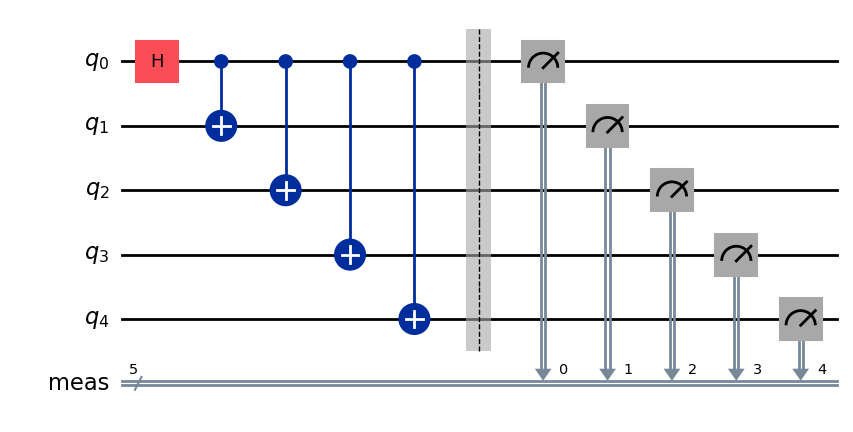

In [89]:
# Original GHZ circuit (naive synthesis)
ghz_circ.draw('mpl')

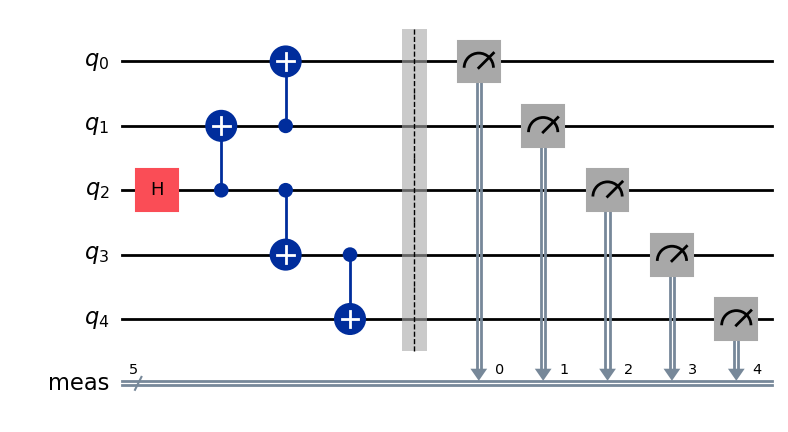

In [90]:
# A better GHZ circuit (smarter synthesis), you learned in a previous lecture
ghz_circ2 = QuantumCircuit(5)
ghz_circ2.h(2)
ghz_circ2.cx(2, 1)
ghz_circ2.cx(2, 3)
ghz_circ2.cx(1, 0)
ghz_circ2.cx(3, 4)
ghz_circ2.measure_all()
ghz_circ2.draw('mpl')

original synthesis:


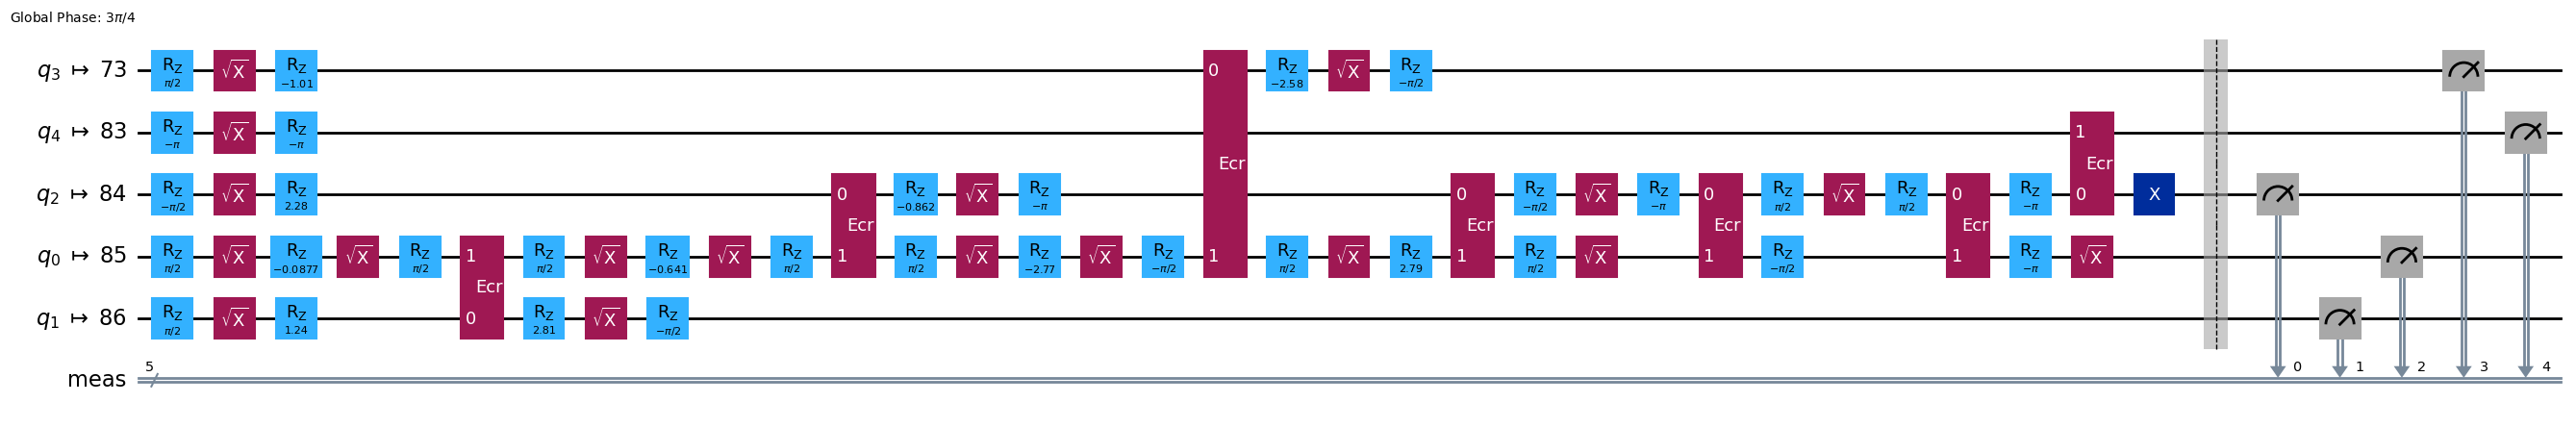

new synthesis:


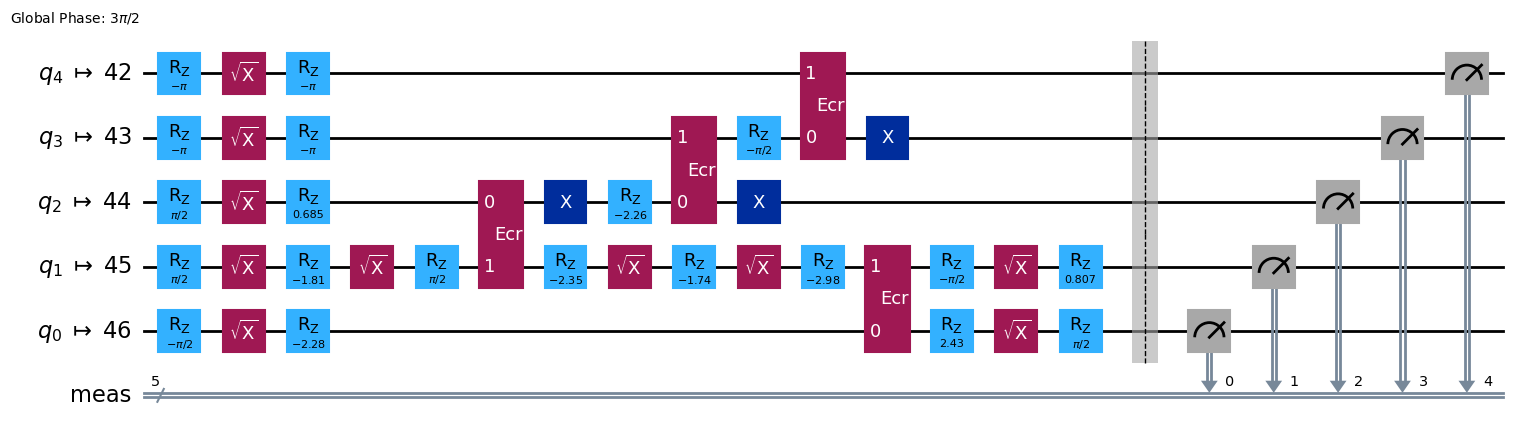

In [91]:
circ_org = pm2.run(ghz_circ)
circ_new = pm2.run(ghz_circ2)
print("original synthesis:"); display(circ_org.draw('mpl', idle_wires=False, fold=-1))
print("new synthesis:"); display(circ_new.draw('mpl', idle_wires=False, fold=-1))

In [92]:
# run the circuits
sampler = Sampler(backend)
job = sampler.run([circ_org, circ_new], shots=10000)
print(f"Job ID: {job.job_id()}")

Job ID: csp30skvnxy0008dexz0


In [ ]:
# REPLACE WITH YOUR OWN JOB IDS
job = service.job("csp30skvnxy0008dexz0")

In [93]:
# get results
result = job.result()
synthesis_org_result = result[0].data.meas.get_counts()
synthesis_new_result = result[1].data.meas.get_counts()

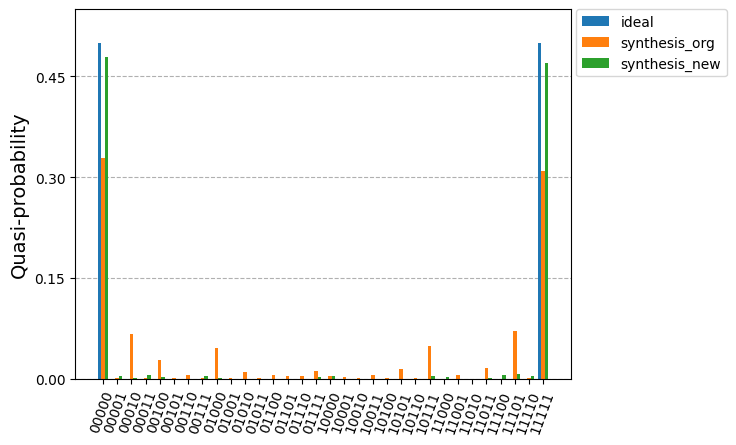

In [94]:
# plot
sim_result = {'0'*5:0.5, '1'*5:0.5}
plot_histogram(
    [result for result in [sim_result, synthesis_org_result, synthesis_new_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "synthesis_org",
        "synthesis_new",
    ],
)

# Appendix 2. Gate decomposition

## General 1-qubit gate decomposition

In [40]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import UGate
phi, theta, lam = Parameter("φ"), Parameter("θ"), Parameter("λ")

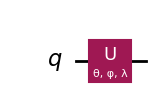

In [41]:
qc = QuantumCircuit(1)
qc.append(UGate(theta, phi, lam), [0])
qc.draw(output="mpl")

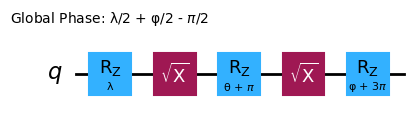

In [42]:
transpile(qc, basis_gates=["rz", "sx"]).draw(output="mpl")

## One-qubit block optimization

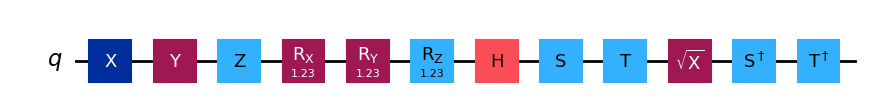

In [43]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(1)
qc.x(0)
qc.y(0)
qc.z(0)
qc.rx(1.23, 0)
qc.ry(1.23, 0)
qc.rz(1.23, 0)
qc.h(0)
qc.s(0)
qc.t(0)
qc.sx(0)
qc.sdg(0)
qc.tdg(0)
qc.draw(output="mpl")

In [44]:
from qiskit.quantum_info import Operator
Operator(qc)

Operator([[ 0.45292511-0.57266982j, -0.66852684-0.14135058j],
          [ 0.14135058+0.66852684j, -0.57266982+0.45292511j]],
         input_dims=(2,), output_dims=(2,))


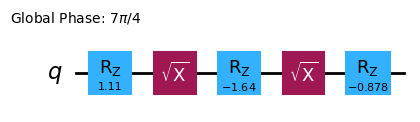

In [45]:
from qiskit import transpile
qc_opt = transpile(qc, basis_gates=["rz", "sx"])
qc_opt.draw(output="mpl")

In [46]:
Operator(qc_opt)

Operator([[-0.45292511+0.57266982j,  0.66852684+0.14135058j],
          [-0.14135058-0.66852684j,  0.57266982-0.45292511j]],
         input_dims=(2,), output_dims=(2,))


In [47]:
Operator(qc).equiv(Operator(qc_opt))

True

## Toffoli decomposition

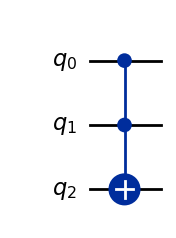

In [48]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.draw(output="mpl")

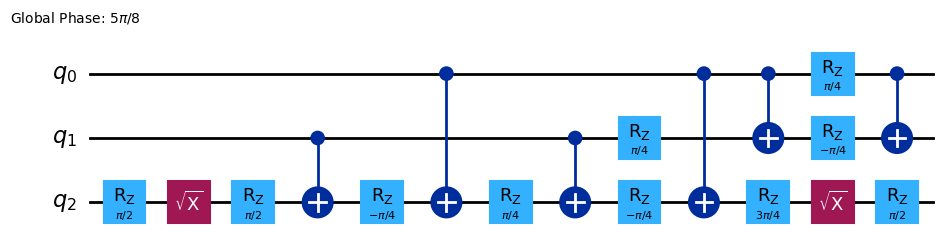

In [49]:
from qiskit import QuantumCircuit, transpile
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc = transpile(qc, basis_gates=["rz", "sx", "cx"])
qc.draw(output="mpl")

## CU gate decomposition

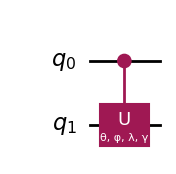

In [50]:
from qiskit.circuit.library.standard_gates import CUGate
phi, theta, lam, gamma = Parameter("φ"), Parameter("θ"), Parameter("λ"), Parameter("γ")
qc = QuantumCircuit(2)
# qc.cu(theta, phi, lam, gamma, 0, 1)
qc.append(CUGate(theta, phi, lam, gamma), [0, 1])
qc.draw(output="mpl")

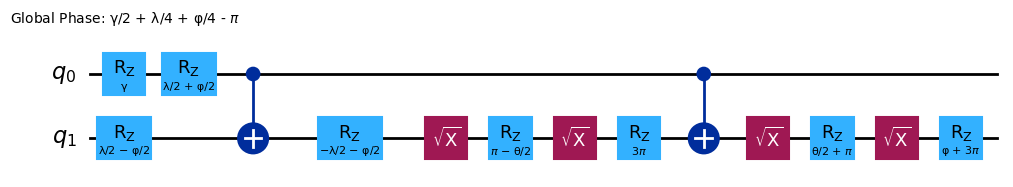

In [51]:
from qiskit.circuit.library.standard_gates import CUGate
phi, theta, lam, gamma = Parameter("φ"), Parameter("θ"), Parameter("λ"), Parameter("γ")
qc = QuantumCircuit(2)
qc.append(CUGate(theta, phi, lam, gamma), [0, 1])
qc = transpile(qc, basis_gates=["rz", "sx", "cx"])
qc.draw(output="mpl")

## CX, ECR, CZ equal up to local Cliffords

Note that $H$(Hadamard), $S$($\pi/2$ Z-rotation), $S^\dagger$($-\pi/2$ Z-rotation), $X$(Pauli X) are all Clifford gates.

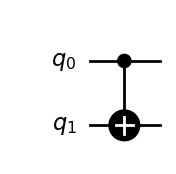

In [52]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.draw(output="mpl", style="bw")

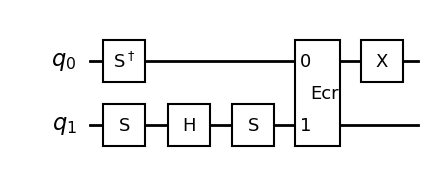

In [53]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=[ "x", "s", "h", "sdg", "ecr"]).draw(output="mpl", style="bw")

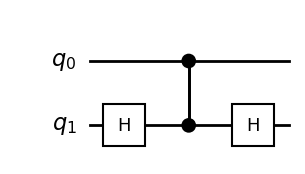

In [54]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=["h", "cz"]).draw(output="mpl", style="bw")

Using IBM backend 1q basis gates {"rz", "sx", "x"},

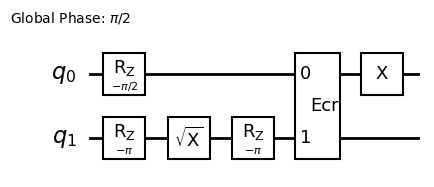

In [55]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=[ "rz", "sx", "x", "ecr"]).draw(output="mpl", style="bw")

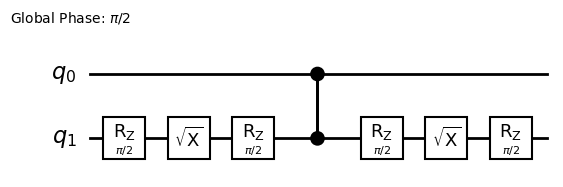

In [71]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=[ "rz", "sx", "x", "cz"]).draw(output="mpl", style="bw")